<a href="https://colab.research.google.com/github/jaekyoungkim/tensor2ml_NLP/blob/main/%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EC%99%80_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EC%9C%BC%EB%A1%9C_%EC%8B%9C%EC%9E%91%ED%95%98%EB%8A%94_%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC(ch7_4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT

In [1]:
# OPEN AI 제안한 GPT(GENERATIVE PRE TRAINING)모델
# 논문 제목 : Improving language understanding by generative pre training 
# 버트보다 앞서 사전학습 기법을 활용
# gpt1 : 비지도 학습으로 사전 학습한 후 학습된 가중치를 활용해 우리가 풀고자 하는 문제에 미세 조정하는 방법론, transformer구조, 대부분의 특징이나 구조가 버트와 비슷
        # transformer의 디코더 구조만 사용함, 순방향 마스크 어텐션을 사용. 학습방식 : 앞의 단어를 활용해 다음 단어를 예측하는 방식으로 사전학습
        # 버트에서는 사전학습에서만 언어모델의 손실값을 사용하는데 gpt1 에서는 본 학습시에도 실제로 학습해야하는 문제의 손실값과 더불어 언어모델의 손실값또한 학습함
        # 12개의 레이어, 117만개 가중치
# gpt2 : 모델구조는 gpt1과 대부분 동일 기존의 디코더에서 각 레이어 직후 레지듀얼 커넥션과 함께 레이어 노말라이제이션이 각 부분 블록의 입력쪽으로 위치가 이동함
        # 48개의 레이어, 1542만개 가중치로 gpt1의 10배

In [ ]:
# 기존의 사전학습 데이터는 한 영역의 텍스트를 사용 (ex. 뉴스기사, 위키피디아)
# gpt2는 다양한 영역의 텍스트를 활용해 사전학습을 진행, 모델이 좀더다양한 문맥과 영역의 글을 이해할 수 있게됨


# GPT2를 활용한 한국어 언어생성 모델 

In [1]:
# 사전학습 모델 : 아주 큰 데이터셋으로 학습해서 가장 일반화된 언어 생성모델을 만드는것이 목적
# 미세조정 모델 : 생성하고자 하는 목적을 가진 데이터셋으로 학습해서 특정한 결과를 얻을 수 있는 언어가 생성될 수 있게하는것이 목적


In [1]:
!pip install gluonnlp

     |████████████████████████████████| 344 kB 9.0 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595731 sha256=582fa0a450fbc256c50f99cec2502ba0a1723a55c5829fd0d4526060f387c2c8
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp


In [2]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 6.9 MB/s 
     |████████████████████████████████| 67 kB 6.4 MB/s 
     |████████████████████████████████| 596 kB 71.7 MB/s 
     |████████████████████████████████| 895 kB 72.2 MB/s 
     |████████████████████████████████| 6.8 MB 58.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
!pip install mxnet

     |████████████████████████████████| 47.3 MB 1.1 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [4]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=67bc2b86f75c6069d3cea7301b0db59d320ff837f059c6b8c64d32b602b21424
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [5]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 8.0 MB/s 


In [73]:
import mxnet
import pandas as pd
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer  
from transformers import TFGPT2LMHeadModel
from transformers import TFGPT2Model
import wget
import zipfile
import tensorflow as tf
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
# 버트의 미세조정 : transformers에서 모델 클래스와 토크나이저 클래스의 두가지를 모두 불러옴
# gpts2의 미세조정 : Transformers에 있는 토크나이저를 사용하지않고, gluonnlp의 모듈을 사용
# 이유는 해당 모델의 경우 허깅페이스에서 학습한 모델이 아니라 skt에서 학습한 모델을 사용한 모델을 사용하기 때문에 skt가 gpt2모델을 학습할때 사용했던 토크나이저인 gluonnlp의 sentencepiecetokenizer를 사용


In [7]:
class GPT2Model(tf.keras.Model):
  def __init__(self, dir_path):
    super(GPT2Model, self).__init__()
    self.gpt2 = TFGPT2LMHeadModel.from_pretrained(dir_path)  # last_hidden_states, past, hidden_states, attentions 순서로 나타냄
  
  def call(self, inputs):
    return self.gpt2(inputs)[0]  # 생성모델을 활용하기 위해서는 vocabulary에 대한 logit값만 활용하도록 첫번째 값인 last_hidden_states를 출력함 


In [8]:
# 학습된 파라미터를 내려받아 준비 다음과 같은 경로로 파라미터를 이동시킨후 모델을 선언
# 경로에는 반드시 config.json과 tf_model.h5파일이 있어야함
wget.download('https://github.com/NLP-kr/tensorflow-ml-nlp-tf2/releases/download/v1.0/gpt_ckpt.zip')
with zipfile.ZipFile('gpt_ckpt.zip') as z:
  z.extractall()

In [9]:
BASE_MODEL_PATH = '/content/gpt_ckpt' # 해당 폴더안에 3개파일이있음, config.json, tf_model.h5, gpt2_kor_tokenizer.spiece

gpt_model = GPT2Model(BASE_MODEL_PATH)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /content/gpt_ckpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [10]:
gpt_model

In [11]:
BATCH_SIZE = 16
NUM_EPOCHS = 10
MAX_LEN = 30


# 사전 학습 모델 문장 생성
# 사전학습된 gpt2는 언어모델을 통해 학습, gpt2는 언어모델이며 텍스트 생성이 가능함
# 텍스트를 모델에 입력할 수 있도록 토크나이저를 생성
# 여기서 사용하는 토크나이저는 앞서 버트에서 활용한 토크나이저 방식과는 다름에 유의
TOKENIZER_PATH = '/content/gpt_ckpt/gpt2_kor_tokenizer.spiece'
# 단어사전과 토크나이저를 저으이함
tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)  


In [12]:
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token=None,
                                               sep_token=None,
                                               cls_token=None,
                                               unknown_token='<unk>',
                                               padding_token='<pad>',
                                               bos_token='<s>',
                                               eos_token='</s>')

In [13]:
vocab

Vocab(size=50000, unk="<unk>", reserved="['<pad>', '<s>', '</s>']")

In [14]:
tokenizer

In [15]:
def tf_top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-99999):
    _logits = logits.numpy()
    top_k = min(top_k, logits.shape[-1])  
    if top_k > 0:
        indices_to_remove = logits < tf.math.top_k(logits, top_k)[0][..., -1, None]
        _logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits = tf.sort(logits, direction='DESCENDING')
        sorted_indices = tf.argsort(logits, direction='DESCENDING')
        cumulative_probs = tf.math.cumsum(tf.nn.softmax(sorted_logits, axis=-1), axis=-1)

        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_indices_to_remove = tf.concat([[False], sorted_indices_to_remove[..., :-1]], axis=0)
        indices_to_remove = sorted_indices[sorted_indices_to_remove].numpy().tolist()
        
        _logits[indices_to_remove] = filter_value
    return tf.constant([_logits])


In [16]:
# 생성한 토크나이저 객체와 사전학습된 gpt2모델을 활용해 문장생성결과를 확인
# 단어 하나가 주어지면 문장을 만들어주는 방식으로 구성


def generate_sent(seed_word, model, max_step=100, greedy=False, top_k=0. , top_p=0.):
  sent = seed_word # 문장생성의 시작이 될 단어
  toked = tokenizer(sent) # 토크나이즈

  for _ in range(max_step): # 문장생성할 수 있는 반복문 
  # 토크나이즈된 단어를 인덱스로 변환하고 모델에 입력값으로 넣어 출력값을 받는다. 
    input_ids = tf.constant([vocab[vocab.bos_token],] + vocab[toked])[None, :]
    outputs = model(input_ids)[:,-1,:] # 문장 출력값중 마지막 단어만 선택

    # 출력을 마쳤다면 출력한 마지막토큰에서 가장 확률이 높은 단어를 선택하거나 확률이 높은 단어중 선택하게끔 해야함

    if greedy: # greedy = true : 문장출력결과에 대해 가장 확률이 높은 단어만 선택, argmax같은 역할
    # false인 경우, 출력한 단어 가운데 확률 또는 순위가 높은 단어만 선택해 무작위로 생성
      gen = vocab.to_tokens(tf.argmax(outputs, axis=-1).numpy().tolist()[0])
    else:      # false인 경우, 출력한 단어 가운데 확률 또는 순위가 높은 단어만 선택해 무작위로 생성
      output_logit = tf_top_k_top_p_filtering(outputs[0], top_k=top_k, top_p=top_p) # topk topp가 모두 0이면 필터링 하지 않음
      gen = vocab.to_tokens(tf.random.categorical(output_logit, 1).numpy().tolist()[0])[0]
    
    if gen == '</s>' : # 문장의 끝을 알리는 토큰인지 확인하기, 
      break # 생성 멈추기
    sent += gen.replace('▁', ' ') # 앞에서 만들어진 토큰들에 추가로 붙임
    toked = tokenizer(sent)

  return sent

In [17]:
print(generate_sent('이때', gpt_model, greedy=True))

이때부터                                                                                                   


In [17]:
print(generate_sent('이때', gpt_model, greedy=True))

이때부터                                                                                                   


In [18]:
print(generate_sent('이때', gpt_model, top_k=0, top_p= 0.95))

이때 말씀 전해 주세요


In [18]:
print(generate_sent('이때', gpt_model, top_k=0, top_p= 0.95))

이때도 내가 그런 말을 하다가 이제 끝났다.


In [21]:
print(generate_sent('이때', gpt_model, top_k=0, top_p= 0.95))

이때 시장에서 나온 산 때문이었다.


In [23]:
print(generate_sent('이때', gpt_model, top_k=0, top_p= 0.95))

이때까지만 추석을 맞아 집이라도


In [24]:
print(generate_sent('이때', gpt_model, top_k=0, top_p= 0.95))

이때 방금 들어온 1단계인데요.


In [18]:
print(generate_sent('이때', gpt_model, top_k=0, top_p= 0.95))

이때만 해도 이경규 씨를 죽이는 거죠.


In [70]:
# 1. top k sampling : 순위안에 해당하는 어휘만 샘플링 해서 어휘를 예측, topk값이 높을수록 무작위 샘플방식에 가까워지고 낮을수록 탐욕방식
# 각 단어의 확률값을 고려하지 않고, 순위만 고려하는 방식
# 2. top p sampling : 값만 조절하는 방식, 뉴클러스 샘플링이라 함, 확률값의 경계를 top p로 정하면 확률이 가장 높은 순으로 후보단어들을 더했을때 top p가 되는 단어집합에 대해 샘플링
# MLE(최대우도 추정)을 활용해 단어 예측분포에서 가장 확률이 높은 단어를 선택하는 탐욕검색으로 새로운 단어를 예측

In [19]:
!git clone https://github.com/NLP-kr/tensorflow-ml-nlp-tf2.git

Cloning into 'tensorflow-ml-nlp-tf2'...
remote: Enumerating objects: 1725, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 1725 (delta 48), reused 17 (delta 7), pack-reused 1631
Receiving objects: 100% (1725/1725), 201.21 MiB | 28.76 MiB/s, done.
Resolving deltas: 100% (1038/1038), done.
Checking out files: 100% (88/88), done.


In [22]:
# 소셜 텍스트 데이터 전처리하기 (운수좋은날)
# 미세조정할 학습데이터를 구성하기
DATA_IN_PATH = '/content/tensorflow-ml-nlp-tf2/7.PRETRAIN_METHOD/data_in/KOR/'
TRAIN_DATA_FILE = 'finetune_data.txt'

sents = [s[:-1] for s in open(DATA_IN_PATH + TRAIN_DATA_FILE, encoding='utf-8').readlines()]
# 학습데이터는 소설 텍스트를 먼저 문장별로 분리해둔 텍스트 데이터이다. 



In [23]:
sents

['그때에 김첨지는 대수롭지 않은듯이,',
 '만일 김첨지가 주기를 띠지 않았던들 한 발을 대문에 들여놓았을 제 그곳을 지배하는 무시무시한 정적(靜寂) ― 폭풍우가 지나간 뒤의 바다 같은 정적이 다리가 떨렸으리라.',
 '마음대로 할 양이면 거기 있는 모든 먹음먹이를 모조리 깡그리 집어삼켜도 시원치 않았다 하되 배고픈 이는 위선 분량 많은 빈대떡 두 개를 쪼이기도 하고 추어탕을 한 그릇청하였다.',
 '하고 추근추근하게도 그 여자의 들고 있는 일본식 버들고리짝에 제 손을 대었다.',
 '흡뜬 눈은 조금 바루어졌건만 이슬이 맺히었다.',
 '김첨지는 교묘하게도 정말 꾀꼬리 같은 소리를 내었다.',
 '하고 어린애 모양으로 손뼉을 치며 웃는다.',
 '응아 소리도 입에서 나는 게 아니고 마치 뱃속에서 나는 듯하였다.',
 '그러자 그 돈벌 용기가 병자에 대한 염려를 사르고 말았다.',
 '“설렁탕을 사다 놓았는데 왜 먹지를 못하니, 왜 먹지를 못하니…… 괴상하게도 오늘은!',
 '제발 덕분에 집에 붙어 있어요.',
 '한꺼번에 이런 금액을 불러라도 본 지가 그 얼마 만인가!',
 '기어이 일 원 어치를 채워서 곱배기 한 잔씩 더 먹고 나왔다.',
 '기적(奇蹟)',
 '거기 마침 마마님이신지 여학생이신지 (요새야 어디 논다니와 아가씨를 구별할 수가 있던가) 망토를 잡수시고 비를 맞고 서 있겠지.',
 '그래 그는 이전에도 여러 번 해본 일이라 바로 정거장 앞 전차 정류장에서 조금 떨어지게 사람 다니는 길과 전찻길 틈에 인력거를 세워 놓고 자기는 그 근처를 빙빙 돌며 형세를 관망하기로 하였다.',
 '하면서 풀매질을 친다.',
 '이런 말을 하며 일변 돈을 줍는다.',
 '문안에(거기도 문밖은 아니지만) 들어간답시는 앞집 마마님을 전찻길까지 모셔다 드린 것을 비롯으로 행여나 손님이 있을까 하고 정류장에서 어정어정하며 내리는 사람 하나하나에게 거의 비는 듯한 눈결을 보내고 있다가 마침내 교원인 듯한 양복쟁이를 동광학교(東光學校)까지 태워다 주기로 되었다.',
 '앓는

In [24]:
input_data = []
output_data = []

for s in sents:
  tokens = [vocab[vocab.bos_token], ] + vocab[tokenizer(s)] + [vocab[vocab.eos_token],]
  input_data.append(tokens[:-1]) # 입력 / 마지막 단어를 예측해야하므로 마지막 단어 이전까지
  output_data.append(tokens[1:]) # 출력 / 맨앞 다음 토큰에서 맨뒤토큰까지 출력으로 이용


In [27]:
vocab[vocab.bos_token]

0

In [28]:
vocab[vocab.eos_token]

1

In [26]:
print(input_data)

[[0, 47437, 47522, 47675, 47442, 47437, 47633, 48120, 47445, 47441, 47437, 47455, 47467, 48139, 47445, 47437, 47676, 47459, 48090, 47438, 47453], [0, 47437, 47494, 47471, 47437, 47633, 48120, 47445, 47448, 47437, 47483, 47449, 47462, 47437, 48358, 47445, 47437, 47676, 47748, 47705, 47493, 47437, 47450, 47437, 47554, 47444, 47437, 47455, 47518, 47442, 47437, 47493, 47524, 47951, 47748, 47444, 47437, 47481, 47437, 47522, 47857, 47444, 47437, 47445, 47669, 47451, 47441, 47437, 47555, 47460, 47555, 47460, 47450, 47437, 47468, 47502, 47478, 49878, 5, 47480, 47437, 48863, 47437, 47829, 47939, 47544, 47448, 47437, 47445, 47491, 47568, 47437, 47878, 47443, 47437, 47609, 47439, 47437, 47764, 47459, 47437, 47468, 47502, 47438, 47437, 47439, 47473, 47448, 47437, 48010, 47946, 47474, 47473, 47490, 47440], [0, 47437, 47538, 47659, 47455, 47446, 47437, 47558, 47437, 47615, 47438, 47516, 47437, 47578, 47449, 47437, 47477, 47441, 47437, 47542, 47837, 47437, 48012, 47659, 48012, 47438, 47462, 47437, 47

In [27]:
print(output_data)

[[47437, 47522, 47675, 47442, 47437, 47633, 48120, 47445, 47441, 47437, 47455, 47467, 48139, 47445, 47437, 47676, 47459, 48090, 47438, 47453, 1], [47437, 47494, 47471, 47437, 47633, 48120, 47445, 47448, 47437, 47483, 47449, 47462, 47437, 48358, 47445, 47437, 47676, 47748, 47705, 47493, 47437, 47450, 47437, 47554, 47444, 47437, 47455, 47518, 47442, 47437, 47493, 47524, 47951, 47748, 47444, 47437, 47481, 47437, 47522, 47857, 47444, 47437, 47445, 47669, 47451, 47441, 47437, 47555, 47460, 47555, 47460, 47450, 47437, 47468, 47502, 47478, 49878, 5, 47480, 47437, 48863, 47437, 47829, 47939, 47544, 47448, 47437, 47445, 47491, 47568, 47437, 47878, 47443, 47437, 47609, 47439, 47437, 47764, 47459, 47437, 47468, 47502, 47438, 47437, 47439, 47473, 47448, 47437, 48010, 47946, 47474, 47473, 47490, 47440, 1], [47437, 47538, 47659, 47455, 47446, 47437, 47558, 47437, 47615, 47438, 47516, 47437, 47578, 47449, 47437, 47477, 47441, 47437, 47542, 47837, 47437, 48012, 47659, 48012, 47438, 47462, 47437, 47542

In [25]:
# 데이터 패딩
input_data = pad_sequences(input_data, MAX_LEN, value= vocab[vocab.padding_token])
output_data = pad_sequences(output_data, MAX_LEN, value= vocab[vocab.padding_token])

In [30]:
vocab[vocab.padding_token]

3

In [26]:
input_data = np.array(input_data, dtype = np.int64)
output_data = np.array(output_data, dtype = np.int64)

In [27]:
input_data

array([[    3,     3,     3, ..., 48090, 47438, 47453],
       [47544, 47448, 47437, ..., 47473, 47490, 47440],
       [47455, 48459, 47437, ..., 47688, 47439, 47440],
       ...,
       [    3,     3,     3, ..., 47445, 47440, 47654],
       [47451, 47516, 47437, ..., 47688, 47439, 47440],
       [47544, 47475, 47463, ..., 47471, 47627, 47774]])

In [28]:
output_data

array([[    3,     3,     3, ..., 47438, 47453,     1],
       [47448, 47437, 47445, ..., 47490, 47440,     1],
       [48459, 47437, 47671, ..., 47439, 47440,     1],
       ...,
       [    3,     3,     3, ..., 47440, 47654,     1],
       [47516, 47437, 47522, ..., 47439, 47440,     1],
       [47475, 47463, 47437, ..., 47627, 47774,     1]])

In [32]:
input_data.shape

(284, 30)

In [33]:
output_data.shape

(284, 30)

In [29]:
# 소설 텍스트 미세 조정 모델 학습
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def accuracy_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask    
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

In [30]:
gpt_model.compile(loss = loss_function, optimizer =tf.keras.optimizers.Adam(1e-4), metrics=[accuracy_function])

In [31]:
history = gpt_model.fit(input_data, output_data, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, validation_split = 0.1)

Epoch 1/10
16/16 [==============================] - 23s 293ms/step - loss: 4.1056 - accuracy_function: 0.1791 - val_loss: 2.8321 - val_accuracy_function: 0.2213
Epoch 2/10
16/16 [==============================] - 2s 118ms/step - loss: 2.8756 - accuracy_function: 0.2451 - val_loss: 2.4481 - val_accuracy_function: 0.2640
Epoch 3/10
16/16 [==============================] - 2s 118ms/step - loss: 2.4539 - accuracy_function: 0.2804 - val_loss: 2.3074 - val_accuracy_function: 0.2941
Epoch 4/10
16/16 [==============================] - 2s 118ms/step - loss: 2.1764 - accuracy_function: 0.3075 - val_loss: 2.2479 - val_accuracy_function: 0.3175
Epoch 5/10
16/16 [==============================] - 2s 118ms/step - loss: 1.9458 - accuracy_function: 0.3278 - val_loss: 2.2155 - val_accuracy_function: 0.3372
Epoch 6/10
16/16 [==============================] - 2s 118ms/step - loss: 1.7452 - accuracy_function: 0.3478 - val_loss: 2.2423 - val_accuracy_function: 0.3556
Epoch 7/10
16/16 [=====================

In [45]:
DATA_OUT_PATH = '/content/data_out'
model_name = 'tf2_gpt2_fintuned_model'

save_path = os.path.join(DATA_OUT_PATH, model_name)

if not os.path.exists(save_path):
    os.makedirs(save_path)

gpt_model.gpt2.save_pretrained(save_path)

loaded_gpt_model = GPT2Model(save_path)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /content/data_out/tf2_gpt2_fintuned_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [32]:
generate_sent('이때', gpt_model, greedy=True)

'이때                                                                                                    '

In [33]:
generate_sent('이때', gpt_model, top_k=0, top_p=0.95)
# 소설의 내용과 비슷한 경향이 있지만 앞서 사전학습 모델에서 생성한 바와 같이 다양하게 생성한 문장을 확인 가능
# 재미난 소설이나 노래가사를 만들어 보고 싶다면 다른 흥미로운 소설책의 내용을 가지고 학습해보면 좋음

'이때 의        기쁨은                                                                                       '

In [35]:
generate_sent('이때', gpt_model, top_k=0, top_p=0.95)

'이때에                                                                                                   '

# GPT2를 활용한 한국어 텍스트 분류모델

In [51]:
# GPT2를 활용한 영화리뷰 분류모델
# 버트에서 활용한 네이버 영화 데이터셋을 활용
# 전체적인 학습방법은 버트와 대부분 유사함
BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.1
SENT_MAX_LEN = 39


In [48]:
# 네이버 영화 리뷰 데이터 전처리
TOKENIZER_PATH = '/content/gpt_ckpt/gpt2_kor_tokenizer.spiece'
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                            mask_token = None,
                                            sep_token = '<unused0>',  # 분류를 위한 스페셜 토큰 지정
                                            cls_token = None, 
                                            unknown_token = '<unk>',
                                            padding_token = '<pad>',
                                            bos_token = '<s>',
                                            eos_token = '</s>'
                                            )
# UNUSED0 ~99까지 정하기 가능

In [38]:
DATA_IN_PATH = '/content/tensorflow-ml-nlp-tf2/7.PRETRAIN_METHOD/data_in/KOR'
DATA_OUT_PATH = '/content/tensorflow-ml-nlp-tf2/7.PRETRAIN_METHOD/data_out/KOR'

DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_train.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_test.txt")

train_data = pd.read_csv(DATA_TRAIN_PATH, header=0, delimiter = '\t', quoting= 3)
train_data = train_data.dropna()

In [43]:
train_data.head(5)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [48]:
def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", sent)
    return sent_clean
import re


In [52]:

train_data_sents = []
train_data_labels = []
for train_sent, train_label in train_data[['document', 'label']].values:
  train_tokenized_text = vocab[tokenizer(clean_text(train_sent))]

  tokens = [vocab[vocab.bos_token]]
  tokens += pad_sequences([train_tokenized_text], SENT_MAX_LEN, value = vocab[vocab.padding_token], padding='post').tolist()[0]

  tokens += [vocab[vocab.eos_token]]

  train_data_sents.append(tokens)
  train_data_labels.append(train_label)



In [54]:
train_data_sents = np.array(train_data_sents, dtype = np.int64)
train_data_labels = np.array(train_data_labels, dtype = np.int64)


In [55]:
train_data_sents

array([[    0, 47437, 47485, ...,     3,     3,     1],
       [    0, 47437, 48640, ...,     3,     3,     1],
       [    0, 47437, 47851, ...,     3,     3,     1],
       ...,
       [    0, 47437, 47438, ...,     3,     3,     1],
       [    0, 47437, 47614, ...,     3,     3,     1],
       [    0, 47437, 47450, ...,     3,     3,     1]])

In [56]:
train_data_labels

array([0, 1, 0, ..., 0, 1, 0])

In [57]:
train_data_sents.shape

(149995, 41)

In [58]:
train_data_labels.shape

(149995,)

In [59]:
# 텍스트를 전처리 하는 방법은 앞서 버트 분류기를 활용해 미세조정했을때와 비슷함
# clean text 함수를 정의해 한글데이터만 사용하도록 필터링하고 토크나이저를 통해 텍스트를 토큰 단위로 나누고 인덱싱
# bos + 입력텍스트 + pad + eos 형태로 구성하기
# 맨 마지막 토큰위치에는 분류할 수 있는 영역으로 cls토큰을 두는 대신 eos토큰을 활용한다.
# 데이터 구성이 앞서 버트 학습 방법과 비슷하고 cls토큰의 위치가 뒤로가고 eos토큰이 대신하는것으로 보면 됨


In [64]:
class TFGPT2Classifier(tf.keras.Model): # tf.keras.Model상속받아 학습과 평가가 가능한 모델 클래스로 구현
  def __init__(self, dir_path, num_class):
    super(TFGPT2Classifier, self).__init__()
    self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
    self.num_class = num_class

    self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
    self.classifier = tf.keras.layers.Dense(self.num_class, kernel_initializer= tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range), name='classifier')

  def call(self, inputs):
    outputs = self.gpt2(inputs) # gpt2의 결과는  last_hidden_states, past, hidden_states, attentions순서로 나타남
    gpt_output = outputs[0][:,-1] # 가장 마지막 토큰만 활용해 분류기를 만든다.

    pooled_output = self.dropout(gpt_output)
    logits = self.classifier(pooled_output)
    return logits

In [65]:
cls_model = TFGPT2Classifier(dir_path = BASE_MODEL_PATH, num_class=2)
optimizer = tf.keras.optimizers.Adam(6.25e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer = optimizer, loss= loss, metrics = [metric])

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at /content/gpt_ckpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [68]:
model_name = "tf2_gpt2_naver_movie"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = cls_model.fit(train_data_sents, train_data_labels, 
                        epochs=NUM_EPOCHS, 
                        batch_size=BATCH_SIZE,
                        validation_split=VALID_SPLIT, 
                        callbacks=[earlystop_callback, cp_callback])

/content/tensorflow-ml-nlp-tf2/7.PRETRAIN_METHOD/data_out/KOR/tf2_gpt2_naver_movie -- Folder create complete 

Epoch 1/3
4219/4219 [==============================] - ETA: 0s - loss: 0.3701 - accuracy: 0.8320
Epoch 00001: val_accuracy improved from -inf to 0.86173, saving model to /content/tensorflow-ml-nlp-tf2/7.PRETRAIN_METHOD/data_out/KOR/tf2_gpt2_naver_movie/weights.h5
4219/4219 [==============================] - 740s 172ms/step - loss: 0.3701 - accuracy: 0.8320 - val_loss: 0.3160 - val_accuracy: 0.8617
Epoch 2/3
4219/4219 [==============================] - ETA: 0s - loss: 0.2884 - accuracy: 0.8770
Epoch 00002: val_accuracy improved from 0.86173 to 0.87433, saving model to /content/tensorflow-ml-nlp-tf2/7.PRETRAIN_METHOD/data_out/KOR/tf2_gpt2_naver_movie/weights.h5
4219/4219 [==============================] - 720s 171ms/step - loss: 0.2884 - accuracy: 0.8770 - val_loss: 0.2984 - val_accuracy: 0.8743
Epoch 3/3
4219/4219 [==============================] - ETA: 0s - loss: 0.2443 - accu

In [71]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

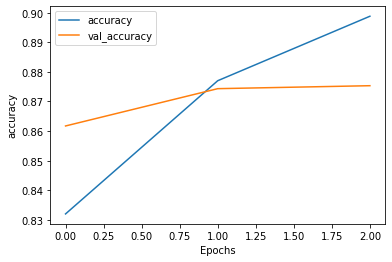

In [74]:
plot_graphs(history, 'accuracy')

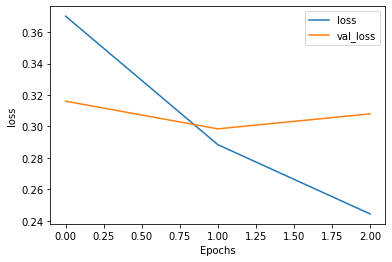

In [75]:
plot_graphs(history, 'loss')

In [76]:
# test데이터에 적용
test_data = pd.read_csv(DATA_TEST_PATH, header=0, delimiter='\t', quoting=3)
test_data = test_data.dropna()
test_data.head(5)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [79]:
test_data_sents = list()
test_data_labels = list()
for test_sent, test_label in test_data[['document','label']].values:
  test_tokenized_text = vocab[tokenizer(clean_text(test_sent))]
  tokens = [vocab[vocab.bos_token]] 
  tokens += pad_sequences([test_tokenized_text],
                          SENT_MAX_LEN,
                          value=vocab[vocab.padding_token],
                          padding = 'post'
                          ).tolist()[0]
  tokens += [vocab[vocab.eos_token]]

  test_data_sents.append(tokens)
  test_data_labels.append(test_label)

test_data_sents = np.array(test_data_sents, dtype = np.int64)
test_data_labels = np.array(test_data_labels, dtype = np.int64)



In [81]:
print("num sents, labels {}, {}".format(len(test_data_sents), len(test_data_labels)))

num sents, labels 49997, 49997


In [82]:
cls_model.load_weigths(checkpoint_path)
results = cls_model.evaluate(test_data_sents, test_data_labels, batch_size= 1024)
# 87.13% 정확도

49/49 [==============================] - 66s 1s/step - loss: 0.3129 - accuracy: 0.8713
test loss, test acc:  [0.3128508925437927, 0.8713122606277466]


# GPT2를 활용한 한국어 자연어 추론 모델 

In [83]:
# 자연어 추론모델을 미세조정하기 위한 베이스 모델은 앞에서본 TFGPT2CLASSIFIER 와 KORNLI데이터셋을 활용
import os
import tensorflow as tf
from transformers import TFGPT2Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
BATCH_SIZE = 32
NUM_EPOCHS = 3
SENT_MAX_LEN = 31

# Load Train dataset

TRAIN_SNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'snli_1.0_train.kor.tsv')
TRAIN_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'multinli.train.ko.tsv')
DEV_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.dev.ko.tsv')

# 실제 데이터 불러오기
train_data_snli = pd.read_csv(TRAIN_SNLI_DF, header=0, delimiter='\t', quoting=3)
train_data_xnli = pd.read_csv(TRAIN_XNLI_DF, header=0, delimiter='\t', quoting=3)
dev_data_xnli = pd.read_csv(DEV_XNLI_DF, header=0, delimiter='\t', quoting=3)

# 데이터 두개를 하나로 합치기 두문장에 대한 태스크이기때문임
train_data_snli_xnli = train_data_snli.append(train_data_xnli)
train_data_snli_xnli = train_data_snli_xnli.dropna() # 공란있는 행 제거
train_data_snli_xnli = train_data_snli_xnli.reset_index() # 인덱스 리셋

dev_data_xnli = dev_data_xnli.dropna()

print("Total # dataset: train - {}, dev - {}".format(len(train_data_snli_xnli), len(dev_data_xnli)))

# 데이터셋 구성 :BOS + 입력텍스트영역1 + PAD + SEP + 입력 텍스트영역2 + PAD + EOS


Total # dataset: train - 942808, dev - 2490


In [84]:
def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", " ", sent)
    return sent_clean


In [85]:
train_data_sents = list()
for train_sent_1, train_sent_2 in train_data_snli_xnli[['sentence1', 'sentence2']].values:
    train_tokenized_sent_1 = vocab[tokenizer(clean_text(train_sent_1))]
    train_tokenized_sent_2 = vocab[tokenizer(clean_text(train_sent_2))]

    tokens = [vocab[vocab.bos_token]] 
    tokens += pad_sequences([train_tokenized_sent_1], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.sep_token]]  
    tokens += pad_sequences([train_tokenized_sent_2], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.eos_token]]

    train_data_sents.append(tokens)    

train_data_sents = np.array(train_data_sents, dtype=np.int64)

In [86]:
dev_data_sents = []

for dev_sent_1, dev_sent_2 in dev_data_xnli[['sentence1', 'sentence2']].values:
    dev_tokenized_sent_1 = vocab[tokenizer(clean_text(dev_sent_1))]
    dev_tokenized_sent_2 = vocab[tokenizer(clean_text(dev_sent_2))]

    tokens = [vocab[vocab.bos_token]] 
    tokens += pad_sequences([dev_tokenized_sent_1], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.sep_token]]  
    tokens += pad_sequences([dev_tokenized_sent_2], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.eos_token]]

    dev_data_sents.append(tokens)    

dev_data_sents = np.array(dev_data_sents, dtype=np.int64)

In [88]:
label_dict = {"entailment" :0, "contradiction" :1, "neutral" : 2}
def convert_int(label): 
  num_label = label_dict[label]
  return num_label


In [90]:
train_data_snli_xnli.head(3)

,index,sentence1,sentence2,gold_label
0,0,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 경쟁을 위해 말을 훈련시키고 있다.,neutral
1,1,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 식당에서 오믈렛을 주문하고 있다.,contradiction
2,2,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,사람은 야외에서 말을 타고 있다.,entailment


In [91]:
train_data_snli_xnli['gold_label_int'] = train_data_snli_xnli['gold_label'].apply(convert_int)
train_data_labels = np.array(train_data_snli_xnli['gold_label_int'], dtype= int)

dev_data_xnli["gold_label_int"] = dev_data_xnli["gold_label"].apply(convert_int)
dev_data_labels = np.array(dev_data_xnli['gold_label_int'], dtype=int)

print("# train labels: {}, #dev labels: {}".format(len(train_data_labels), len(dev_data_labels)))

# train labels: 942808, #dev labels: 2490


In [92]:
# 모델 학습
sim_model = TFGPT2Classifier(dir_path = BASE_MODEL_PATH, num_class=3)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
sim_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at /content/gpt_ckpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [93]:
model_name = "tf2_gpt_kornli"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)


/content/tensorflow-ml-nlp-tf2/7.PRETRAIN_METHOD/data_out/KOR/tf2_gpt_kornli -- Folder create complete 



In [ ]:
history = sim_model.fit(train_data_sents, train_data_labels, 
                        epochs=NUM_EPOCHS,
                        validation_data=(dev_data_sents, dev_data_labels),
                        batch_size=BATCH_SIZE, 
                        callbacks=[earlystop_callback, cp_callback])

Epoch 1/3
29463/29463 [==============================] - ETA: 0s - loss: 0.8067 - accuracy: 0.6302
Epoch 00001: val_accuracy improved from -inf to 0.62811, saving model to /content/tensorflow-ml-nlp-tf2/7.PRETRAIN_METHOD/data_out/KOR/tf2_gpt_kornli/weights.h5
29463/29463 [==============================] - 7290s 247ms/step - loss: 0.8067 - accuracy: 0.6302 - val_loss: 0.8307 - val_accuracy: 0.6281
Epoch 2/3
29463/29463 [==============================] - ETA: 0s - loss: 0.6599 - accuracy: 0.7177
Epoch 00002: val_accuracy improved from 0.62811 to 0.66345, saving model to /content/tensorflow-ml-nlp-tf2/7.PRETRAIN_METHOD/data_out/KOR/tf2_gpt_kornli/weights.h5
29463/29463 [==============================] - 7272s 247ms/step - loss: 0.6599 - accuracy: 0.7177 - val_loss: 0.7683 - val_accuracy: 0.6635
Epoch 3/3
12188/29463 [===========>..................] - ETA: 1:10:58 - loss: 0.6021 - accuracy: 0.7466

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
# test데이터에 적용하기

# Load Test dataset
TEST_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.test.ko.tsv')

test_data_xnli = pd.read_csv(TEST_XNLI_DF, header=0, delimiter='\t', quoting=3)

In [ ]:
# test_data_xnli = test_data_xnli[:50] # for test

test_data_sents = []

for test_sent_1, test_sent_2 in test_data_xnli[['sentence1', 'sentence2']].values:
    test_tokenized_sent_1 = vocab[tokenizer(clean_text(test_sent_1))]
    test_tokenized_sent_2 = vocab[tokenizer(clean_text(test_sent_2))]

    tokens = [vocab[vocab.bos_token]] 
    tokens += pad_sequences([test_tokenized_sent_1], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.sep_token]]  
    tokens += pad_sequences([test_tokenized_sent_2], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.eos_token]]

    test_data_sents.append(tokens)    

test_data_sents = np.array(test_data_sents, dtype=np.int64)

In [ ]:
# 테스트 데이터의 라벨 숫자로 변경
test_data_xnli["gold_label_int"] = test_data_xnli["gold_label"].apply(convert_int)
test_data_labels = np.array(test_data_xnli['gold_label_int'], dtype=int)

print("# sents: {}, # labels: {}".format(len(test_data_sents), len(test_data_labels)))

In [ ]:
# 테스트 모델에 대한 성능 검증
sim_model.load_weights(checkpoint_path)

results = sim_model.evaluate(test_data_sents, test_data_labels, batch_size=1024)
print("test loss, test acc: ", results)

# GPT2를 활용한 한국어 텍스트 유사도 모델 

In [ ]:
# KorSTS 데이터셋 활용
# 사전학습된 GPT2모델에 미세조정한 후 버트와의 성능을 비교해볼 것

In [ ]:
# 데이터 전처리
# NLI문제에 미세조정하는 경우에 두개의 텍스트를 스페셜 토큰인 SEP토큰을 사이에 넣어서 모델에 입력값으로 사용함
# 텍스트 유사도역시 마찬가지로 두개의 텍스트 사이에 SEP토큰을 두고 입력값을 만드는것을 동일하나 텍스트 위치가 바뀐 두개의 입력값이 필요
# BOS SENT1 PAD SEP SENT2 PAD EOS
# BOS SENT2 PAD SEP SENT1 PAD EOS
# 두 문장이 수반 혹은 종속적인 관계가 아닌 독립적인 두문장, 선후관계 존재하지않음
TRAIN_STS_DF = os.path.join(DATA_IN_PATH, 'KorSTS', 'sts-train.tsv')
DEV_STS_DF = os.path.join(DATA_IN_PATH, 'KorSTS', 'sts-dev.tsv')
train_data = pd.read_csv(TRAIN_STS_DF, header=0, delimiter ='\t', quoting= 3)
dev_data = pd.read_csv(DEV_STS_DF, header=0, delimiter ='\t', quoting= 3)

print("total # dataset : train-{}, dev-{}".format(len(train_data), len(dev)data))
